In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import requests


In [2]:
spark = SparkSession.builder.appName("Loan credit card").getOrCreate()

url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

response = requests.get(url)
json_data = response.json()

df = spark.read.json(spark.sparkContext.parallelize([json_data]))

df.show(5)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [3]:
print(f"rows: {df.count()}")
print(len(df.columns))
df.describe().show()
df.printSchema()
df.columns

rows: 511
10
+-------+--------------+------------------+------------------+------------------+------------+------+------+-------+-------------+-------------+
|summary|Application_ID|Application_Status|    Credit_History|        Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+-------+--------------+------------------+------------------+------------------+------------+------+------+-------+-------------+-------------+
|  count|           511|               511|               511|               511|         511|   511|   511|    511|          511|          511|
|   mean|          null|              null|0.8434442270058709|0.5588865096359743|        null|  null|  null|   null|         null|         null|
| stddev|          null|              null|0.3637375108305913|0.7904073771519635|        null|  null|  null|   null|         null|         null|
|    min|      LP001002|                 N|                 0|                 0|    Graduate|Female|  high|     No| 

['Application_ID',
 'Application_Status',
 'Credit_History',
 'Dependents',
 'Education',
 'Gender',
 'Income',
 'Married',
 'Property_Area',
 'Self_Employed']

In [4]:
status = response.status_code

print(f"Status Code: {status}")

Status Code: 200


In [5]:
CDW_SAPP_loan_application = df
CDW_SAPP_loan_application.show(5)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


### Load data into MYSQL Database called creditcard_capstone

In [6]:
CDW_SAPP_loan_application.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

### 5.1 Find and plot the percentage of applications approved for self-employed applicants.

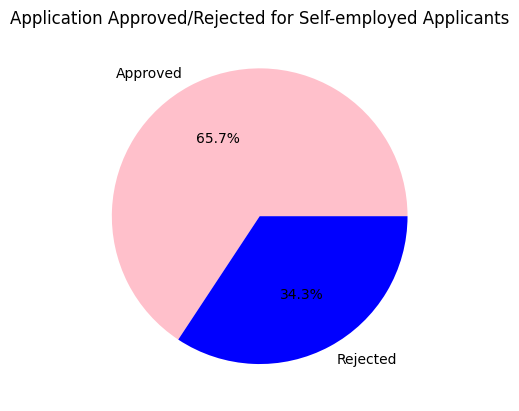

In [9]:

self_employed_df = df.filter(df['Self_Employed'] == 'Yes')
total_applications = self_employed_df.count()
approved_applications = self_employed_df.filter(df['Application_Status'] == 'Y').count()
percentage_approved = (approved_applications / total_applications) * 100

Self_Employed_rejected = 100 - percentage_approved

# Plot the percentage of approved and rejected applications
labels = ['Approved', 'Rejected']
sizes = [percentage_approved, Self_Employed_rejected]
colors = ['pink', 'blue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Application Approved/Rejected for Self-employed Applicants')
plt.show()


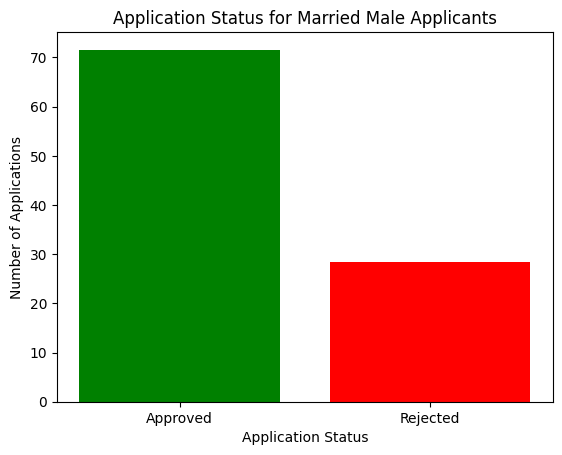

In [8]:
married_male = df.filter((df['Married'] == 'Yes') & (df['Gender'] =='Male'))
total_applications = married_male.count()
approved_applications = married_male.filter(df['Application_Status'] == 'Y').count()
percentage_approved = (approved_applications / total_applications) * 100

married_male_rejected = 100 - percentage_approved

labels = ['Approved', 'Rejected']
sizes = [percentage_approved, married_male_rejected]
colors = ['green', 'red']

plt.bar(labels, sizes, color=colors)
plt.title('Application Status for Married Male Applicants')
plt.xlabel('Application Status')
plt.ylabel('Number of Applications')
plt.show()
